In [1]:
%matplotlib inline
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr
from osgeo import gdal

from plot_and_table_functions import ( read_raster,
                                       make_plot,
                                       make_scatter,
                                       discrete_cmap,
                                       discrete_irreg_cmap,
                                       discrete_random_cmap )

In [8]:
def create_file_reference( component_name ):
    '''
    This is a simple convenience function that will form a path and filename to a
    given water budget component
    '''
    # specify the prefix, path to SWB2 output, timeframe, and resolution
    output_path = '../output/'
    prefix      = 'maui_'
    start_date  = '2001-01-01'
    end_date    = '2002-12-31'
    ncol        = '1582' # '316'
    nrow        = '1054' # '210'
    return( output_path + prefix + component_name + '__' + start_date + '_to_' 
          + end_date + '__' + nrow + '_by_' + ncol + '.nc' )

### Use xarray to open up a SWB 2.0 output netCDF file

In [9]:
filename = create_file_reference( 'irrigation')
print(f"Attempting to open SWB 2.0 NetCDF grid file: {filename}")

irrigation = xr.open_dataset( filename )

if irrigation is None:
    print(f"Could not open SWB 2.0 NetCDF grid file.")
    sys.exit(1)

Attempting to open SWB 2.0 NetCDF grid file: ../output/maui_irrigation__2001-01-01_to_2002-12-31__1054_by_1582.nc


### Create mask to eliminate any values that are actually ocean cells

C:\Users\smwesten\AppData\Local\Temp\1\ipykernel_25452\2390080293.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  mask_water = 2 * np.zeros( ( irrigation.dims['y'], irrigation.dims['x'] ) ) * np.isnan( irrigation.irrigation.isel(time=0))
C:\Users\smwesten\AppData\Local\Temp\1\ipykernel_25452\2390080293.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  mask_land = 1 * np.ones( ( irrigation.dims['y'], irrigation.dims['x'] ) ) * np.isfinite( irrigation.irrigation.isel(time=0))


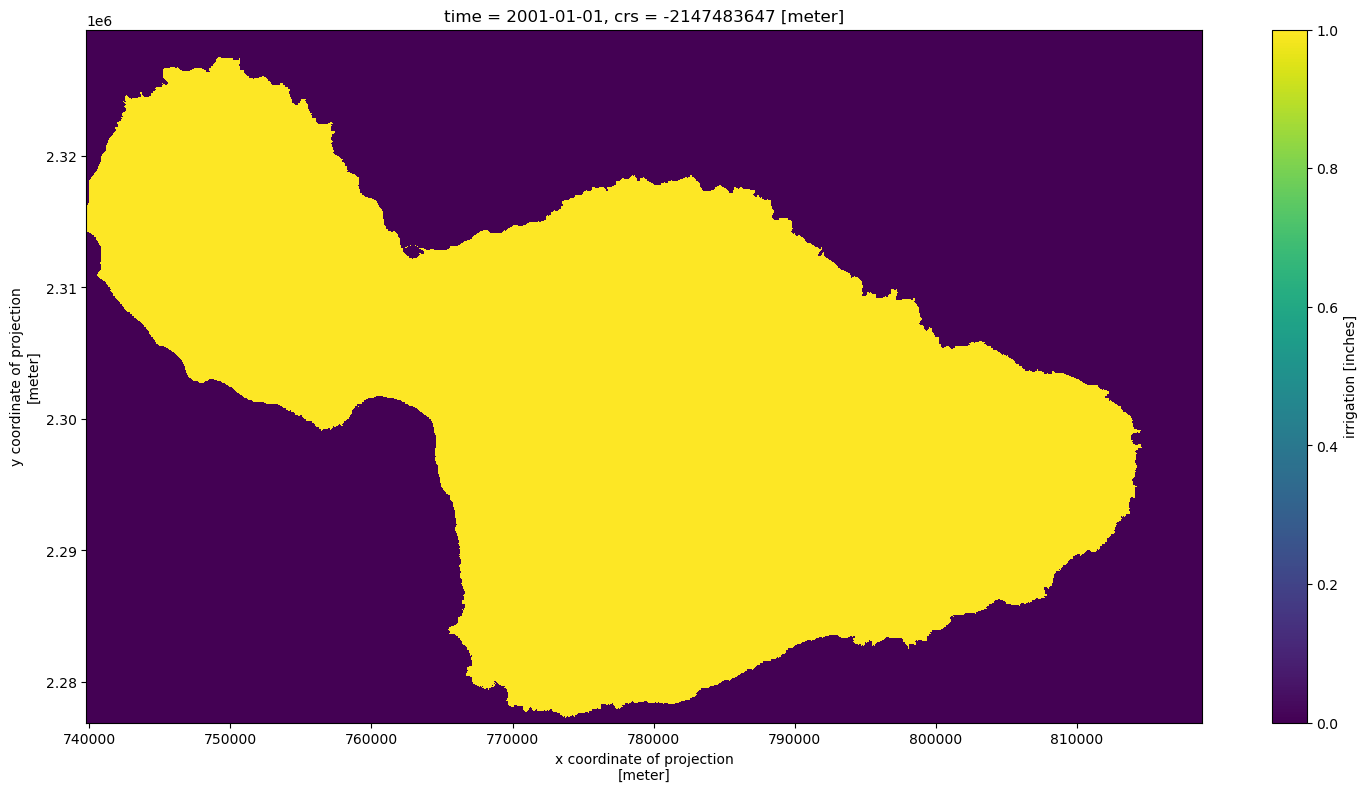

In [10]:
mask_water = 2 * np.zeros( ( irrigation.dims['y'], irrigation.dims['x'] ) ) * np.isnan( irrigation.irrigation.isel(time=0))
mask_land = 1 * np.ones( ( irrigation.dims['y'], irrigation.dims['x'] ) ) * np.isfinite( irrigation.irrigation.isel(time=0))
mask_array = mask_water + mask_land
mask_array.plot(aspect=2, size=9,add_labels=True)

### Add mask information to coords member in xarray object

In [12]:
irrigation.coords['mask'] = (('y','x'), mask_array.data )

In [13]:
irrigation.coords

Coordinates:
  * time     (time) datetime64[ns] 6kB 2001-01-01 2001-01-02 ... 2002-12-31
  * y        (y) float64 8kB 2.33e+06 2.33e+06 2.329e+06 ... 2.277e+06 2.277e+06
  * x        (x) float64 13kB 7.398e+05 7.399e+05 ... 8.188e+05 8.189e+05
    crs      int32 4B ...
    mask     (y, x) float64 13MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

### Sum irrigation over calendar year 2002

In [14]:
annual_irrigation = irrigation.irrigation.sel(time=slice('2002-01-01','2002-12-31'))
annual_sum = annual_irrigation.where( annual_irrigation.mask == 1 ).sum(dim='time')


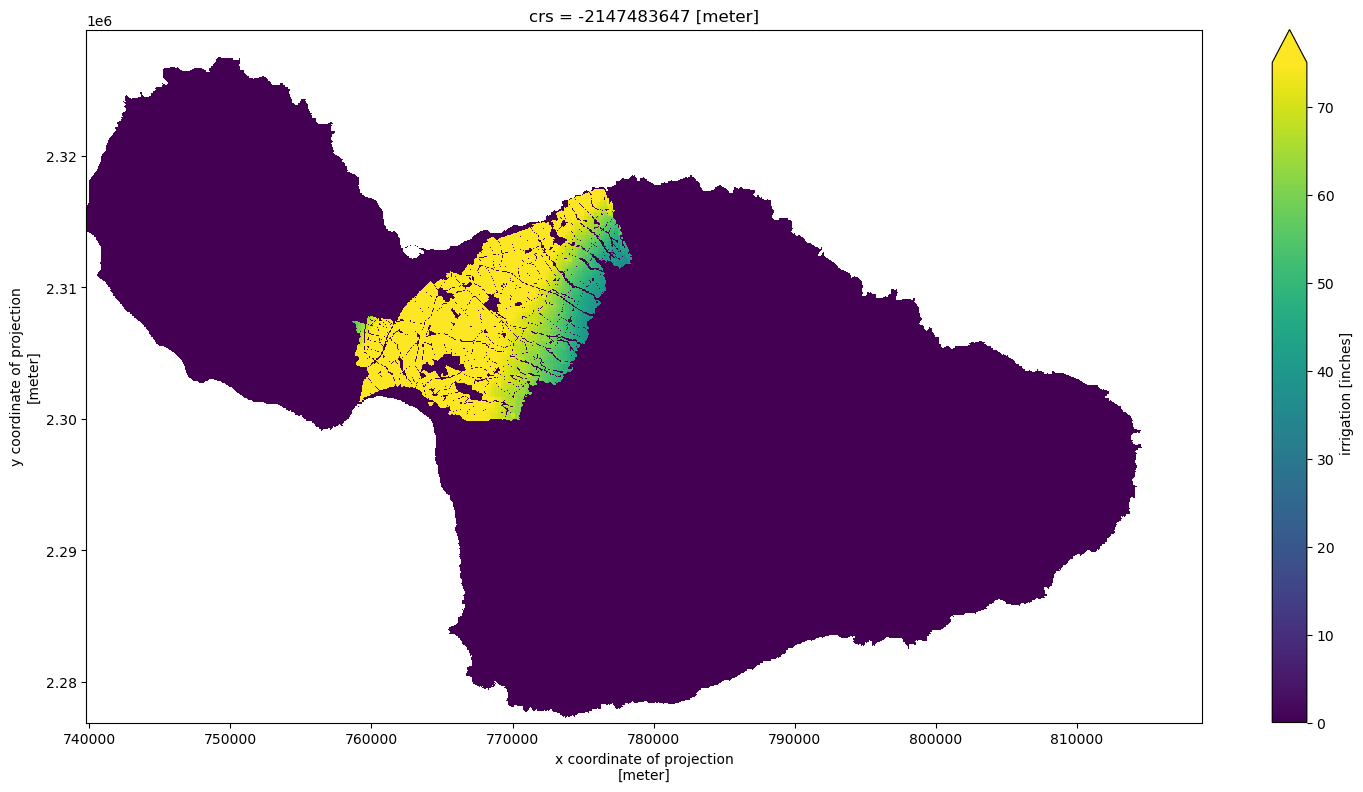

In [15]:
annual_sum.where(annual_sum.mask == 1).plot(aspect=2, size=9, vmax=75., add_labels=True)